In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import os
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import datetime

In [2]:
data=pd.read_csv('sms_eng1.csv')

In [3]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.01)

In [4]:
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

In [5]:
train.head()

,sms,english_inp,english_out
1054,ok for movie tonight shld be leaving on time t...,<start> ok for movie tonight should be leaving...,ok for movie tonight should be leaving on time...
72,oh ok i didnt know what you meant yep i am bab...,<start> oh ok i didnt know what you meant yep ...,oh ok i didnt know what you meant yep i am bab...
1631,ya shld b ok lor i thk guys nd smethg to hug o...,<start> yeah should be ok i think guys need so...,yeah should be ok i think guys need something ...
1370,yup free in the afternoon we must go buy jigs...,<start> yes are you free in the afternoon we m...,yes are you free in the afternoon we must go b...
171,den where is e nearest mrt station tt u can me...,<start> then where is the nearest mrt station ...,then where is the nearest mrt station that you...


In [6]:
tokenizer_sms = Tokenizer(oov_token=True)
tokenizer_sms.fit_on_texts(train["sms"].values)
tokenizer_eng=Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_eng.fit_on_texts(train['english_inp'].values)
vocab_size_eng=len(tokenizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_sms=len(tokenizer_sms.word_index.keys())
print(vocab_size_sms)

3080
4318


In [7]:
class Dataset:
    def __init__(self, data, tokenizer_sms, tokenizer_eng, max_len):
        self.encoder_inps = data['sms'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tokenizer_eng = tokenizer_eng
        self.tokenizer_sms = tokenizer_sms
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_sms.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tokenizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data_get = []
        for j in range(start, stop):
            data_get.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1),axis=0) for samples in zip(*data_get)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [8]:
train_dataset = Dataset(train, tokenizer_sms, tokenizer_eng, 60)
test_dataset  = Dataset(validation, tokenizer_sms, tokenizer_eng, 60)

train_dataloader = Dataloder(train_dataset, batch_size=64)
test_dataloader = Dataloder(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 60) (64, 60) (64, 60)


In [9]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


In [10]:
import pickle
with open('glove_vectors', 'rb') as f:
    glove = pickle.load(f)
    glove_words =  set(glove.keys())
from numpy import zeros
vocab = len(tokenizer_eng.word_index)+1
essay_mat = zeros((vocab, 300))
for word, i in tokenizer_eng.word_index.items():
    if word in glove_words:
        vector = glove[word]
        essay_mat[i] = vector

In [11]:
encoder_inputs = Input(shape=(None,))
embedding1 = Embedding(input_dim=vocab_size_sms+1, output_dim=100, input_length=60, name="embedding_layer_encoder")(encoder_inputs)
encoder_lstm1 = LSTM(256, return_state=True,return_sequences=True)
encoder_lstm2 = LSTM(256, return_state=True,return_sequences=True)
encoder_outputs1,_,_ = encoder_lstm1(embedding1)
encoder_outputs2, state_h, state_c = encoder_lstm2(encoder_outputs1)
encoder_states = [state_h, state_c]
decoder_inputs=Input(shape=(None,))
embedding2 = Embedding(input_dim=vocab_size_eng+1, output_dim=300, input_length=60,trainable=False,weights=[essay_mat], name="embedding_layer_decoder")(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs,_,_ = decoder_lstm(embedding2,initial_state=encoder_states) 
decoder_dense = Dense(vocab_size_eng, activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)
model=Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_layer_encoder (Embedd (None, None, 100)    431900      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, None, 256),  365568      embedding_layer_encoder[0][0]    
_______________________________________________________________________________________

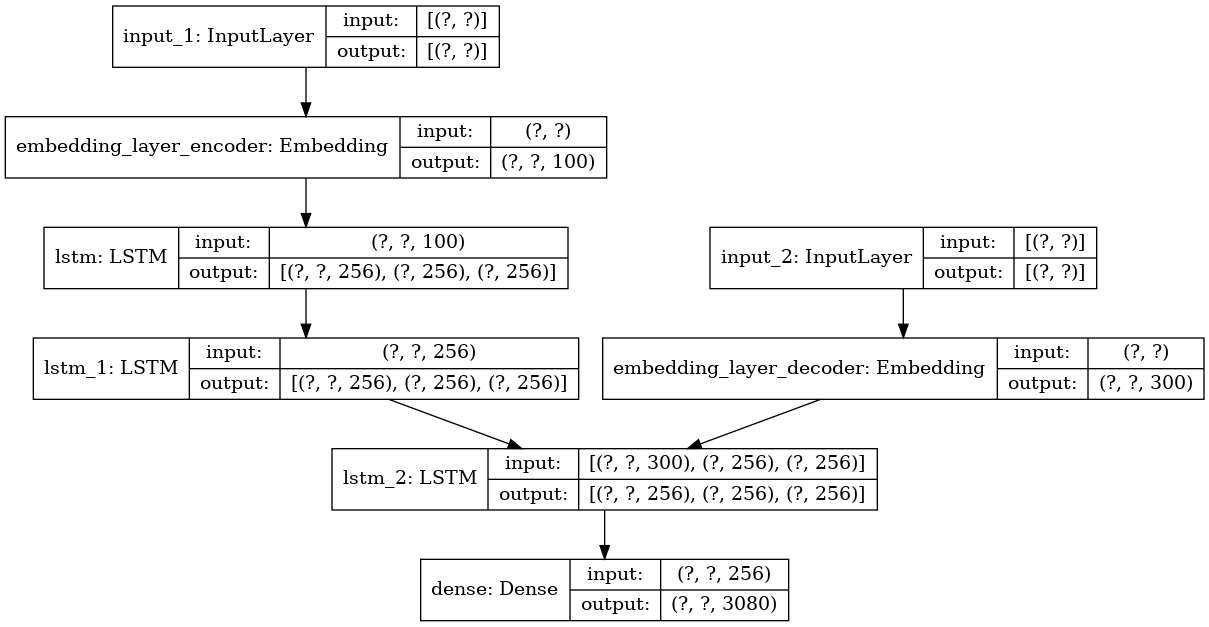

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
%load_ext tensorboard
log_dir="log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
red=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=1)
model.fit(train_dataloader, batch_size=64, epochs=260, validation_data=train_dataloader,callbacks=[tensorboard,red,earlystop])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/260
30/30 [==============================] - 31s 1s/step - loss: 0.8774 - val_loss: 0.8600
Epoch 2/260
30/30 [==============================] - 30s 1s/step - loss: 0.8633 - val_loss: 0.8477
Epoch 3/260
30/30 [==============================] - 31s 1s/step - loss: 0.8496 - val_loss: 0.8346
Epoch 4/260
30/30 [==============================] - 31s 1s/step - loss: 0.8396 - val_loss: 0.8248
Epoch 5/260
30/30 [==============================] - 31s 1s/step - loss: 0.8302 - val_loss: 0.8160
Epoch 6/260
30/30 [==============================] - 31s 1s/step - loss: 0.8216 - val_loss: 0.8099
Epoch 7/260
30/30 [==============================] - 31s 1s/step - loss: 0.8139 - val_loss: 0.8014
Epoch 8/260
30/30 [==============================] - 31s 1s/step - loss: 0.8067 - val_loss: 0.7929
Epoch 9/260
30/30 [==============================] - 31s 1s/step - loss: 0.7985 - val_loss: 0.7870
Epoch 10/260
30/30 

In [15]:
print(model.layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdbb4e46b50>, <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fdbb4e5da90>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdbb4e5ded0>, <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7fdbb4e5df90>, <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fdbb4d1c610>, <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7fdbb4de6f50>, <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7fdbb4d64d50>, <tensorflow.python.keras.layers.core.Dense object at 0x7fdbb3299490>]


In [22]:
def predict(input_sentence):
    encoder_sms=tokenizer_sms.texts_to_sequences([input_sentence])
    encoder_pad=pad_sequences(encoder_sms,maxlen=60,padding='post',dtype='int32')
    embed=model.layers[1](encoder_pad)
    encoder_out1,_,_=model.layers[3](embed)
    encoder_out2,encoder_h,encoder_c=model.layers[5](encoder_out1)
    start_index = tokenizer_eng.word_index['<start>']
    start_index=np.reshape(start_index,(1,1))
    out=[]
    for j in range(60):
        decemb=model.layers[4](start_index)
        decoder_out,decoder_h,decoder_c=model.layers[6](decemb,[encoder_h,encoder_c])
        output=model.layers[7](decoder_out)
        encoder_h,encoder_c=decoder_h,decoder_c
        prob=np.argmax(output)
        start_index=np.reshape(prob,(1,1))
        out.append(tokenizer_eng.index_word[prob])
        if tokenizer_eng.index_word[prob]=='<end>':
            break
    return ' '.join(out)  

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
%%time
from nltk.translate import bleu_score
sms_inp=validation['sms'].values
eng_inp=validation['english_out'].values
score=[]
for i in range(len(sms_inp)):
    try:
        prediction=predict(sms_inp[i])
        print('sms sentence:',sms_inp[i])
        print('correct sentence:',eng_inp[i])
        print('prediction:',prediction)
        score.append(bleu_score.sentence_bleu(eng_inp[i],prediction))
    except:
        pass
    
print('bleu_score:',np.average(score))

sms sentence: hey ill b at terminal 2
correct sentence: hey ill be at terminal 2 <end>
prediction: hey are we going out tomorrow <end>
sms sentence: me jordan what take u so long to sms my hp number
correct sentence: i am jordan what is taking you so long to sms my handphone number <end>
prediction: im going to orchard now already haha i didnt know what to do about it anymore <end>
sms sentence: no more stairs liao its bad for your knees so stoppin is quite good wat homework r u rushing 1pm flight ok mayb i go snatch josssticks u know
correct sentence: no more stairs its bad for your knees so stopping is quite good what homework are you rushing 1pm flight ok maybe i should go to snatch joss sticks do you know <end>
prediction: hi how is your evening i hope a nice to see you to see you but it should be having a good time maybe just say it is today <end>
sms sentence: is tat yijue
correct sentence: is that yijue <end>
prediction: are you yijue are you from <end>
sms sentence: hey  going 